In [ ]:
print('hello')

hello


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import pandas as pd
import numpy as np

In [4]:
base_dir = '/content/gdrive/My Drive/Digikala Contest/Sentiment Analysis'

In [5]:
!unzip '/content/gdrive/My Drive/Digikala Contest/Sentiment Analysis/nlp_comments_users.zip' -d '/content/gdrive/My Drive/Digikala Contest/Sentiment Analysis'

Archive:  /content/gdrive/My Drive/Digikala Contest/Sentiment Analysis/nlp_comments_users.zip
replace /content/gdrive/My Drive/Digikala Contest/Sentiment Analysis/test_users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
train_df = pd.read_csv(base_dir + '/train_users.csv') 
test_df = pd.read_csv(base_dir + '/test_users.csv')

In [7]:
train_df.head(5)

,id,title,comment,advantages,disadvantages,title_fa_product,title_fa_category,is_buyer,verification_status,rate
0,0,NaN,مثل بقیه محصولات الکل دار پوست رو خشک نمیکنه,NaN,NaN,ژل ضد عفونی کننده دست شون مدل Aloevera حجم 300...,ضدعفونی کننده,1,1,100.0
1,1,Redmi 8,با این مبلغ اگه امکانات و ارزش خرید واستون مهم...,"[""رم4\r"",""قیمت نسبت به سایر برندها\r"",""طراحی و...","[""نداشتن هندزفری""]",گوشی موبایل شیائومی مدل Redmi 8 M1908C3IG دو س...,گوشی موبایل,1,1,80.0
2,2,عالی,خوبه فقط کج و کوله بدستم رسید ولی پسرم خیلی خو...,NaN,NaN,ماسک کودک طرح سگ نگهبان مدل رابل,ایفای نقش,1,1,100.0
3,3,NaN,در کل خوب بود ولی متاسفانه درب محصول شکسته بود...,NaN,NaN,مایع ضدعفونی کننده میوه و سبزیجات من مدل WT حج...,ضدعفونی کننده سطوح,1,1,70.0
4,4,NaN,من که خیلی باهاش حال کردم فقط من که همیشه L می...,NaN,NaN,تی شرت آستین کوتاه مردانه باینت کد 323-1 btt,تی شرت و پولوشرت مردانه,1,1,72.0


In [8]:
test_df.head(5)

,id,title,comment,advantages,disadvantages,title_fa_product,title_fa_category,is_buyer
0,0,با کیفیت,بسته بندی بهداشتی و کیفیت عالی,NaN,NaN,گوش پاک کن کتابی پنبه ریز بسته 200 عددی,گوش پاک کن,1
1,1,گوشی موبایل شیائومی,این گوشی فوق‌العاده است,"[""این گوشی همه چیش فوق‌العاده است از دوربین تا...","[""اصلا هیچ نقاط ضعفی نداره ""]",گوشی موبایل شیائومی مدل Redmi Note 8 M1908C3JG...,گوشی موبایل,1
2,2,NaN,صداش قطع میشه باتریشم خیییلی ضعیفه,NaN,NaN,هدفون بی سیم مدل inpods 12,هدفون، هدست و هندزفری,1
3,3,NaN,بنظرم‌ خوبه,NaN,NaN,خمیر دندان نسیم مدل Feluoride Protection مقدار...,خمیر دندان,1
4,4,عااالیه,عااالیه,"[""عاااالیه""]",NaN,کرم موبر صورت و بدن سینره حجم 100 میلی لیتر,کرم موبر,1


In [9]:
train_texts = train_df['comment'].tolist()
test_texts = test_df['comment'].tolist()

In [10]:
train_labels = train_df['rate'].tolist()
train_labels = [int(rate // 5) for rate in train_labels]

In [11]:
num_classes = len(set(train_labels))
num_classes

21

In [12]:
len(train_df), len(test_df)

(264399, 19399)

In [ ]:
train_texts[100]

'تطابق قیمت و کیفیت. رطوبت خوب و کافی، بوی خوب. از محصولات ایرانی حمایت کنیم.'

In [ ]:
# train_texts_cleaned = []

# TODO: cleaning the text, removing stopwords, maybe use Hazm?
# for text in train_texts:
#   text_cleaned = ' '.join(filter(lambda x: (x[0] != '@') and (x[:7] != 'http://'), text.split()))
#   train_texts_cleaned.append(text_cleaned)

# train_texts = train_texts_cleaned
import re

# train_texts = [print(type(sentence)) for sentence in train_texts]

# the empty comments are float, we replace them with an empty string
for i in range(len(train_texts)):
  if type(train_texts[i]) == float:
    train_texts[i] = ''

In [ ]:
# the empty comments are float, we replace them with an empty string
for i in range(len(test_texts)):
  if type(test_texts[i]) == float:
    test_texts[i] = ''

In [ ]:
from urllib.request import urlopen
import gzip

In [ ]:
embedding_file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz'))

In [ ]:
fasttext_embeddings = {}
# put words as dict indexes and vectors as dict values

for line in embedding_file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  fasttext_embeddings[word] = vector

In [ ]:
vocab_size = 20000
max_length = 40 # Estimated average length of comments
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
from keras.utils import to_categorical

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
train_labels = to_categorical(train_labels)

test_padded = np.array(test_padded)

In [ ]:
num_tokens = len(word_index) + 1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = fasttext_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 47084 words (41998 misses)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

In [ ]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 2, mode='min')

In [ ]:
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K


def smape(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  diff = math_ops.abs(
      (y_true - y_pred) / math_ops.add(math_ops.abs(y_true), math_ops(y_pred))
      )
  return 100. * K.mean(diff, axis=-1)

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(num_tokens, embedding_dim,
                                                       embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                       trainable=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')
                             ])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         26724900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                525       
Total params: 26,812,233
Trainable params: 26,812,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 5
history = model.fit(train_padded, train_labels, batch_size=128, epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/5
1860/1860 [==============================] - 464s 249ms/step - loss: 1.8201 - accuracy: 0.3500 - val_loss: 1.7694 - val_accuracy: 0.3698
Epoch 2/5
1860/1860 [==============================] - 462s 249ms/step - loss: 1.7079 - accuracy: 0.3944 - val_loss: 1.7573 - val_accuracy: 0.3719
Epoch 3/5
1860/1860 [==============================] - 461s 248ms/step - loss: 1.6381 - accuracy: 0.4236 - val_loss: 1.7877 - val_accuracy: 0.3660
Epoch 4/5
1860/1860 [==============================] - 460s 247ms/step - loss: 1.5577 - accuracy: 0.4537 - val_loss: 1.8434 - val_accuracy: 0.3624


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


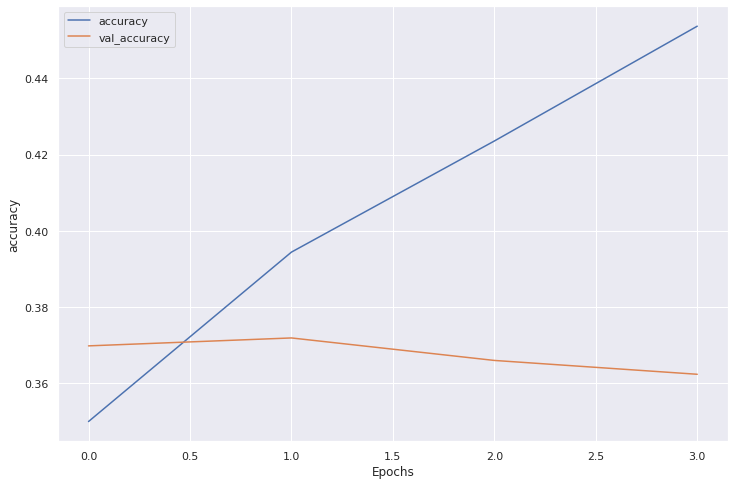

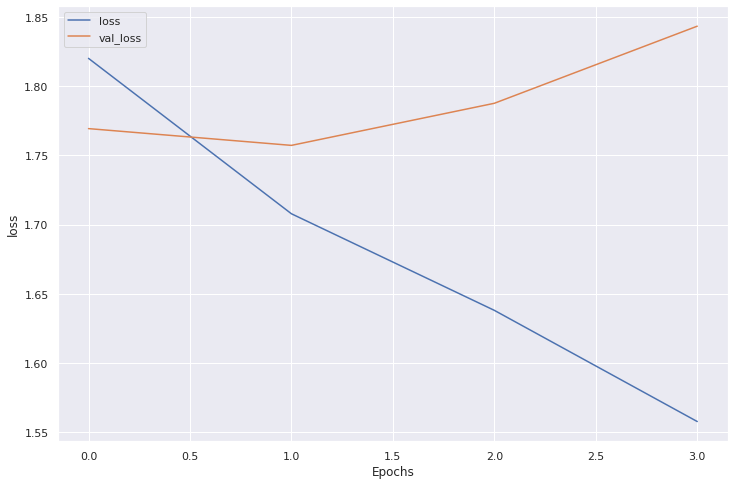

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

def plot_graphs(model_history, ploting_variable):
  plt.plot(model_history.history[ploting_variable])
  plt.plot(model_history.history['val_' + ploting_variable])
  plt.xlabel("Epochs")
  plt.ylabel(ploting_variable)
  plt.legend([ploting_variable, 'val_' + ploting_variable])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
test_predict = model.predict(test_padded)

In [ ]:
test_predict[0]

array([3.0416101e-01, 5.1653626e-07, 1.0962953e-06, 9.7831207e-07,
       8.7055465e-05, 2.0588506e-05, 2.3688437e-05, 3.0242574e-05,
       5.2800274e-04, 1.3755733e-04, 5.1162048e-04, 5.6828721e-04,
       1.5337239e-01, 2.1261028e-03, 3.4695016e-03, 6.0898880e-03,
       1.3587798e-01, 1.3162438e-02, 1.0298843e-02, 7.6939631e-03,
       3.6183822e-01], dtype=float32)

In [ ]:
predictions = [np.argmax(prediction_i) for prediction_i in test_predict]
predictions = [prediction * 5 for prediction in predictions]
predictions[:10]

[100, 100, 20, 0, 100, 100, 100, 0, 60, 80]

In [ ]:
 predictions_df = test_df.copy()
 predictions_df.drop(labels=
                   ['title', 'comment', 'advantages', 'disadvantages', 'title_fa_product', 'title_fa_category', 'is_buyer'],
                   axis=1, inplace=True)
 predictions_df['rate'] = predictions

In [ ]:
predictions_df

,id,rate
0,0,100
1,1,100
2,2,20
3,3,0
4,4,100
...,...,...
19394,19394,80
19395,19395,100
19396,19396,60
19397,19397,80


In [ ]:
predictions_df.to_csv(base_dir + '/predictions.csv', index= False)